<a href="https://colab.research.google.com/github/silasmaverick/jupyter/blob/master/billboard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

O projeto se inicia com a instalação de um banco de dados Postgres na nuvem na plataforma Heroku. Heroku é uma plataforma (Paas) que tem a oferta de serviço que permite aos desenvolvedores realizar implantação, escalonamento e gerenciamento de aplicativos sem complicações. Foi construida com base (na Iaas) cloud da AWS

https://devcenter.heroku.com/categories/reference

O primeiro passo foi criar a conta na Heroku. Após a conta criada, É necessário criar um app clicando no botão new. Configurar o nome e preferências. No menu superior, acessar a sessão overview e em seguida configure Addons. No campo de busca escolher Heroku Postgres. 

Criado o serviço, voltar na aba overview e clicar sobre o link do Postgres. Na nova aba, no menu superior escolher Settings e depois view credentials. Ali está as credenciais para manejo do banco de dados.

Para gerenciar o banco de dados usei a IDE dBeaver 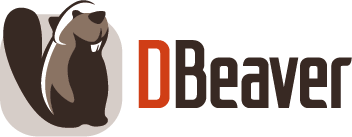

Usei o  dataset https://www.kaggle.com/dhruvildave/billboard-the-hot-100-songs , um arquivo CSV contendo o ranking de músicas da billboard top 100. 

Por limitações do plano Free do heruko (que só permite a inserção de uma carga com 10 mil linhas), vamos analisar o arquivo e modifica-lo para não exceder esse limite.

Para isso vamos usar o Python e sua biblioteca Pandas

In [ ]:
#importação da biblioteca pandas para analise do arquivo CSV
import pandas as pd
#criação do dataframe baseado no CSV
data = pd.read_csv('/home/silas/Downloads/charts.csv')

In [ ]:
#ver uma pequena parte da estrutura do arquivo
data.head()

In [ ]:
#resumo estatístico do dataframe 
data.describe()

Foi constatado que o arquivo possui 328487 linhas. O primeiro lançamento foi em 04/08/1958. Para prosseguir vamos diminuir a quantidade de linhas para analisar um recorte menor de dados e consequentemente poder usar o Postgres Heroku e fazer as consultas SQL
  

In [ ]:
data.iloc[10000]

O registro da linha 10000 mostrou uma música de agosto de 2019. Para não ficar com um ano "picado" vamos usar apenas dados do ano de 2021 e 2020. Também teremos uma gordura para fazer inserções se necessário.

In [ ]:
#Criando um novo dataframe e adicionando os dados com a exclusão usando a data como filtro 
nw1 = data.drop(data[data.date < '2020-01-01'].index)

In [ ]:
#Agora temos pouco mais de 8 mil linhas
nw1.describe()

In [ ]:
#Agora usar o novo arquivo para dar carga no banco de dados a partir dele
nw1.to_csv('blbxxi.csv', index=False)

Com o arquivo em mãos. Vamos criar o esqueleto da tabela no banco de dados. E a importação do arquivo para as linhas e colunas. Os comandos SQL são feitos no dBeaver


In [ ]:
CREATE TABLE PUBLIC."Billboard" (
	"date" DATE NULL
	,"rank" int4 NULL
	,song VARCHAR(300) NULL
	,artist VARCHAR(300) NULL
	,"last-week" int4 NULL
	,"peak-rank" int4 NULL
	,"weeks-on-board" int4 NULL
	);


Em construção...